# A Python tutorial on validating gVirtualXRay: Analytic simulation vs. Monte Carlo simulation in the monochromatic case

**Purpose:** In this notebook, we aim to demonstrate that gVirtualXRay is able to generate analytic simulations on GPU comparable to images generated with the state-of-the-art Monte Caro simulation packages. We use here a monochromatic source.

**Material and Methods:** We simulate an image with gVirtualXRay and compare it with a ground truth image. For this purpose, we use [Gate],(http://www.opengatecollaboration.org/) a wrapper for CERN's state-of-the-art Monte Caro simulation tool: [Geant4](https://geant4.web.cern.ch/).

In our simulation the source-to-object distance (SOD) is 1000mm, and the source-to-detector distance (SDD) is 1125mm. The beam spectrum is monochromatic, with an enegy of 80 keV.aluminium

![Geometric parameters](../doc/setup.png)

The sample is made of a 70x70x15mm box of water, in which 5 columns of 3 spheres of different radii (2, 3.5, and 5mm) have been inserted. A given material is associated to the spheres of each column (bone (cortical), blood (whole), brain (grey/white matter), breast tissue, and adipose tissue). The columns are ordered in decreasing density. We use the definitions of tissue substitutes provided in the [ICRU Report 44](https://www.icru.org/report/tissue-substitutes-in-radiation-dosimetry-and-measurement-report-44/) by the [International Commission on Radiation Units and Measurements](https://www.icru.org/). The material composition is available at [https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html).

![Sample composition](../doc/sample.png)

**Results:** The [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD), between the two simulated images is MAPE **????**%. The [zero-mean normalised cross-correlation](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)) is **????**%. 
<!-- The [Structural Similarity Index (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity) is ???%.  -->
As MAPE is low (close to 0), and ZNCC is high (close to 100%), we can conclude that X-ray images simulated with gVirtualXRay on GPU in milliseconds are comparable to Monte Carlo simulations ran on supercomputers for days.

## Import packages

In [1]:
%matplotlib inline

import os # Locate files

import math
import numpy as np # Who does not use Numpy?
import pandas as pd # Load/Write CSV files

import matplotlib
# old_backend =  matplotlib.get_backend() 
# matplotlib.use("Agg")  # Prevent showing stuff

from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt # Plotting
from matplotlib.colors import LogNorm # Look up table
from matplotlib.colors import PowerNorm # Look up table
import matplotlib.colors as mcolors

font = {'family' : 'serif',
        #'weight' : 'bold',
         'size'   : 22
       }
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

from scipy.stats import pearsonr # Compute the correlatio coefficient

from skimage.util import compare_images # Checkboard comparison between two images
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_absolute_percentage_error as mape

from tifffile import imread, imsave # Load/Write TIFF files

import viewscad # Use OpenSCAD to create STL files

# import pyvista as pv # 3D visualisation
# from pyvista import themes

# import cma # Optimise the parameters of the noise model

import gvxrPython3 as gvxr # Simulate X-ray images

import json2gvxr # Set gVirtualXRay and the simulation up

SimpleGVXR 1.0.1 (2021-10-12T11:29:58) [Compiler: GNU g++] on Linux
gVirtualXRay core library (gvxr) 1.1.5 (2021-10-12T11:29:44) [Compiler: GNU g++] on Linux


## Reference image

We first load the reference image that has been simulated using [Gate](http://www.opengatecollaboration.org/) wrapper for CERN's [Geant4](https://geant4.web.cern.ch/). Here we ignore scattering.

In [2]:
Image = imread("Gate_data/energy_monoE.tif")
Full_field = imread("Gate_data/flat_monoE.tif")
Dark_field = np.zeros(Full_field.shape)

Projections are then corrected to account for variations in beam homogeneity and in the pixel-to-pixel sensitivity of the detector. This is the projection with flat-field correction ($\mathbf{Proj}$):
\begin{equation}
\mathbf{Proj} = \frac{\boldsymbol{I} - \boldsymbol{D}}{\boldsymbol{F} - \boldsymbol{D}}
\label{eq:flat-fields}
\end{equation}
where $\boldsymbol{F}$ (full fields) and $\boldsymbol{D}$ (dark fields) are projection images without sample and acquired with and without the X-ray beam turned on respectively. 
<!-- Note that with an ideal detector ($\boldsymbol{R}_i=E_i$), pixels of $\boldsymbol{D}$ are null, and pixels of $\boldsymbol{F}$ are equal to $\sum_i E_i \; \boldsymbol{N}_i$. 
 -->

We now apply the flat-field correction to `Image`.

In [3]:
gate_image = (Image - Dark_field) / (Full_field - Dark_field)
# gate_image = Image / np.mean(Full_field)

We plot the image using a linear look-up table and a power-law normalisation.

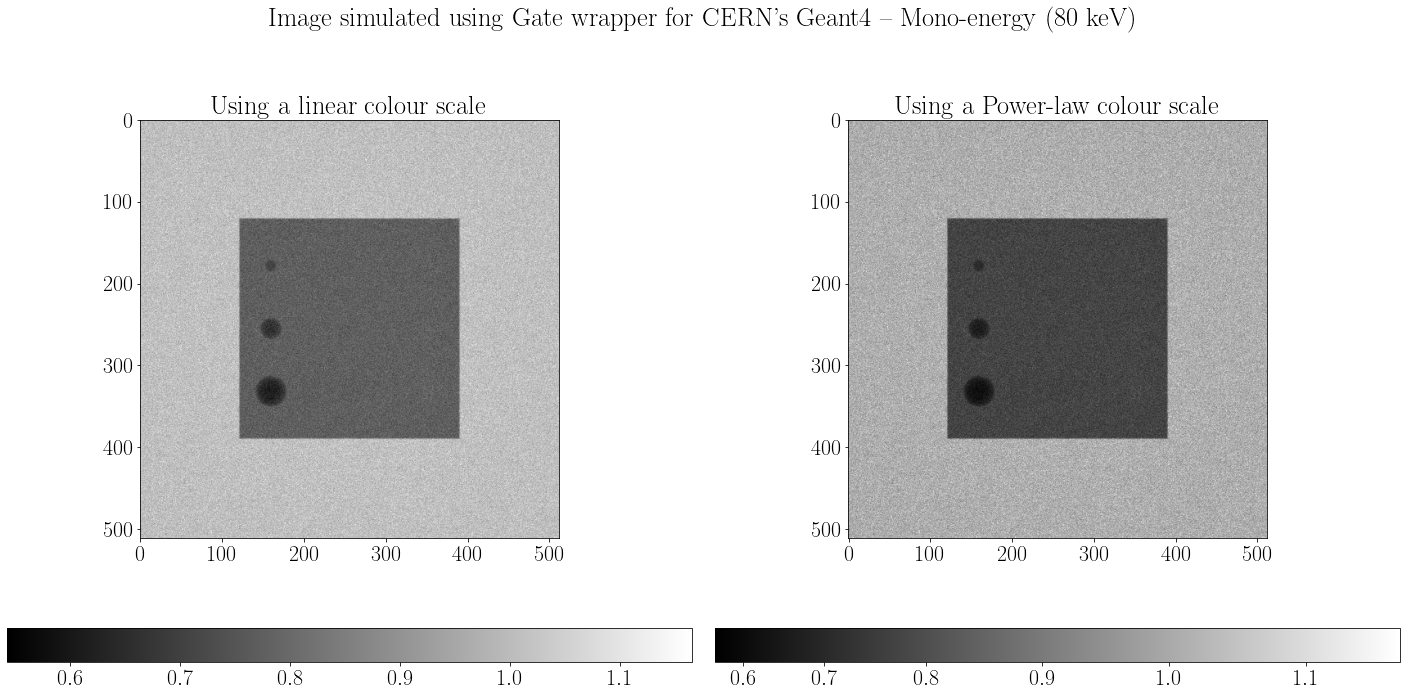

In [4]:
plt.figure(figsize= (20,10))

plt.suptitle("Image simulated using Gate wrapper for CERN's Geant4 -- Mono-energy (80 keV)", y=1.02)

plt.subplot(121)
plt.imshow(gate_image, cmap="gray")
plt.colorbar(orientation='horizontal')
plt.title("Using a linear colour scale")

plt.subplot(122)
plt.imshow(gate_image, norm=PowerNorm(gamma=1./0.75), cmap="gray")
plt.colorbar(orientation='horizontal')
plt.title("Using a Power-law colour scale")

plt.tight_layout()

plt.savefig('plots/reference_from_Gate-monoE-80keV.pdf')
plt.savefig('plots/reference_from_Gate-monoE-80keV.png')

## Setting up gVirtualXRay

Before simulating an X-ray image using gVirtualXRay, we must create an OpenGL context.

In [5]:
json2gvxr.initGVXR("notebook-2.json", "OPENGL")

Create an OpenGL context: 800x450
gvxrStatus:	Create window 0
gvxrStatus:	Create window 
0 0 500 500
OpenGL renderer:   NVIDIA GeForce RTX 2080 Ti/PCIe/SSE2
OpenGL version:    3.2.0 NVIDIA 470.42.01
OpenGL vender:     NVIDIA Corporation
Use OpenGL 4.5.
0 0 800 450


## X-ray source

We create an X-ray source. It is a point source.

In [6]:
json2gvxr.initSourceGeometry()

Set up the beam
	Source position: [0.0, 0.0, 1000.0, 'mm']
	Source shape: PointSource


## Spectrum

The beam spectrum is generated using [SpekPy](https://bitbucket.org/spekpy/spekpy_release/wiki/Home). We decided to use a beam that is clinically appropriate. The chest phantom we used corresponds to a 70kg male patient. For a male chest x-ray, the tube voltage is in the range 80-120kV depending on technique, pathology and equipment used. The total aluminium equivalent filtration is approximately 3.2mm. `verbose=1` below is used to output the beam spectrum for Gate. To disable it, change it to `verbose=0`.

In [7]:
spectrum, unit, k, f = json2gvxr.initSpectrum(verbose=1)

	 1.0 photon of 80 keV


Plot the spectrum

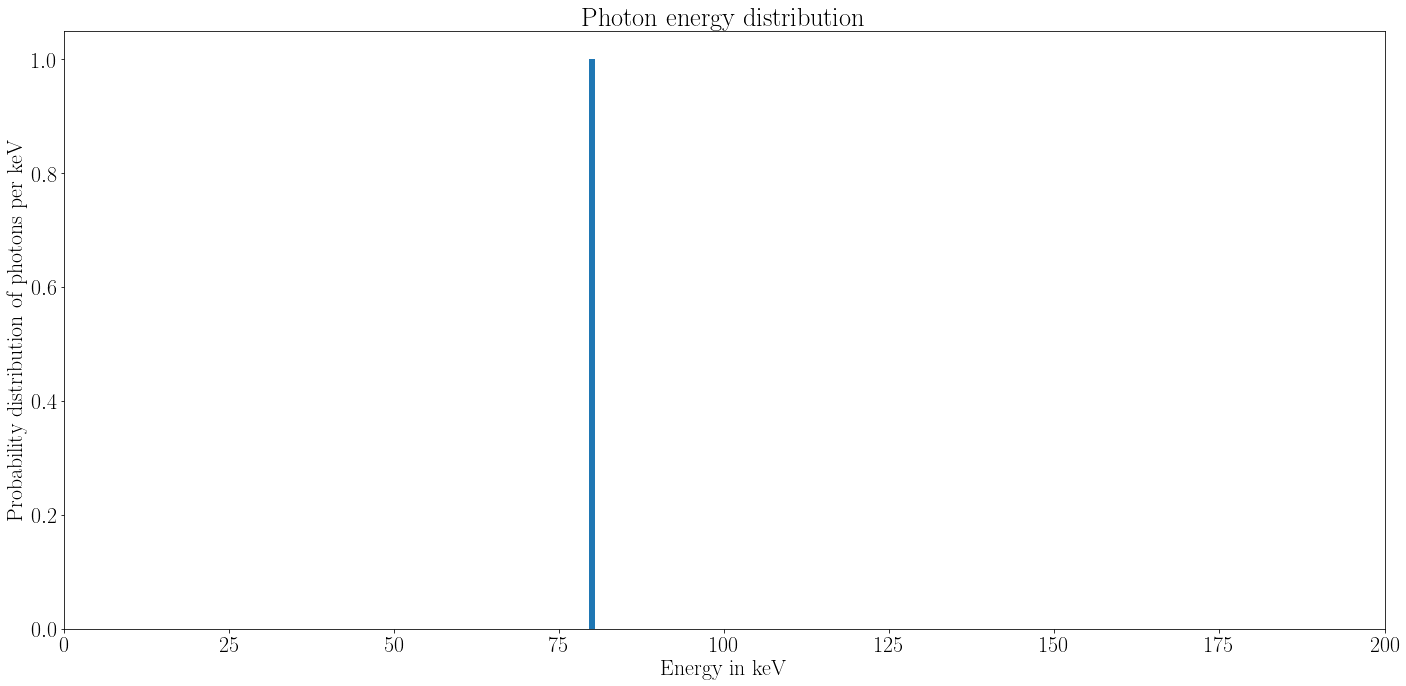

In [8]:
energy_set = sorted(spectrum.keys())
count_set = []

for energy in energy_set:
    count_set.append(spectrum[energy])
    
plt.figure(figsize= (20,10))

plt.bar(k, f / f.sum()) # Plot the spectrum
plt.xlabel('Energy in keV')
plt.ylabel('Probability distribution of photons per keV')
plt.title('Photon energy distribution')

plt.xlim([0, 200])

plt.tight_layout()

plt.savefig('plots/spectrum-monoE-80keV.pdf')
plt.savefig('plots/spectrum-monoE-80keV.png')

## Detector

Create a digital detector

In [9]:
json2gvxr.initDetector()

Set up the detector
	Detector position: [0.0, 0.0, -125.0, 'mm']
	Detector up vector: [0, 1, 0]
	Detector number of pixels: [512, 512]
	Pixel spacing: [0.29296875, 0.29296875, 'mm']
INIT RENDER


## Sample

We now create CAD models using [OpenSCAD](https://openscad.org/) and extract the corresponding STL files.

In [10]:
openscad_make_spheres_str = """

module make_column_of(sphere_radius, height, count)
{
    step = height / (count - 1);
    for (a = [0 : count - 1]) {
        offset = -height / 2 + step * a ;
        translate([0, offset, 0])
            sphere(sphere_radius[a], $fn=25);
    }
}

module make_row_of(radius, count, id)
{
    step = radius / (count - 1);
    for (a = [0 : count - 1]) {
        if (id == -1 || id == a) {
            offset = -radius / 2 + step * a ;
            translate([offset, 0, 0])
                children();
        }
    }
}

module make_spheres(sphere_radius, ring_radius, ring_count, column_height, column_count, id = -1)
{
    make_row_of(radius = ring_radius, count = ring_count, id = id)
        make_column_of(sphere_radius, height = column_height, count = column_count);
}
"""

The matrix

In [11]:
openscad_matrix_str = """

color("red")
    difference() {
        scale([70, 70, 15])
            cube(1, center = true);
        make_spheres([2, 3.5, 5], 50, 5, 40, 3, -1);
}

"""

In [12]:
fname = 'CAD_models/matrix.stl'
if not os.path.isfile(fname):

    r = viewscad.Renderer()
    r.render(openscad_matrix_str + openscad_make_spheres_str, outfile=fname)

In [13]:
openscad_cube_str = """

color("red")
    scale([70, 70, 15])
        cube(1, center = true);

"""

In [14]:
fname = 'CAD_models/cube.stl'
if not os.path.isfile(fname):
    
    r = viewscad.Renderer()
    r.render(openscad_cube_str, outfile='gvxr/input/cube.stl')

The spheres

In [15]:
openscad_col_str_set = []

for i in range(5):
    openscad_col_str_set.append("""
    color("blue")
        make_spheres([2, 3.5, 5], 50, 5, 40, 3, """ + str(i) + ");")
    
    fname = 'CAD_models/col_' + str(i) + '.stl'
    if not os.path.isfile(fname):

        r = viewscad.Renderer()
        r.render(openscad_col_str_set[-1] + openscad_make_spheres_str, outfile=fname)

Load the samples. `verbose=2` is used to print the material database for Gate. To disable it, use `verbose=0` or `verbose=1`.

In [16]:
json2gvxr.initSamples(verbose=2)

Load the 3D data

Bone_Cortical_ICRU_44:file_name:	CAD_models/col_0.stl	nb_faces:	1938	nb_vertices:	5814	bounding_box (in cm):	(-2.99606, -2.19961, -0.496354)	(-2, 2.49901, 0.496354)
 d=1.92 g/cm3 ; n=9 ; state=solid
        +el: name=Hydrogen ; f=0.034
        +el: name=Carbon ; f=0.155
        +el: name=Nitrogen ; f=0.042
        +el: name=Oxygen ; f=0.435
        +el: name=Sodium ; f=0.001
        +el: name=Magnesium ; f=0.002
        +el: name=Phosphor ; f=0.103
        +el: name=Sulfur ; f=0.003
        +el: name=Calcium ; f=0.225

Blood_Whole_ICRU_44: d=1.06 g/cm3 ; n=10 ; state=solid
        +el: name=Hydrogen ; f=0.102
        +el: name=Carbon ; f=0.11
        +el: name=Nitrogen ; f=0.033
        +el: name=Oxygen ; f=0.745
        +el: name=Sodium ; f=0.001
        +el: name=Phosphor ; f=0.001
        +el: name=Sulfur ; f=0.002
        +el: name=Chlorine ; f=0.003
        +el: name=Potassium ; f=0.002
        +el: name=Iron ; f=0.001

Brain_Grey_White_Matter_ICRU_44:file_name:	

In [37]:
mu_water = gvxr.getMassAttenuationFromCompound("H2O", 80, "keV")
print("mu water at 80 keV:", mu_water)
print("thickness: 1.5 cm")

print("0.08 * exp(-mu_water * thickness):", 0.08 * math.exp(-1.5 * mu_water))

mu water at 80 keV: 0.18375873491694744
thickness: 1.5 cm
0.08 * exp(-mu_water * thickness): 0.06072700744441614


## Runing the simulation

Update the 3D visualisation and take a screenshot

In [18]:
gvxr.displayScene()

gvxr.useLighing()
gvxr.useWireframe()
gvxr.setZoom(719.6787109375)
gvxr.setSceneRotationMatrix([0.7624880075454712, 0.09040657430887222, -0.6406543850898743, 0.0,
                             0.05501500517129898, 0.9775413870811462, 0.20342488586902618, 0.0,
                             0.6446591019630432, -0.190354123711586, 0.7403913140296936, 0.0,
                             0.0, 0.0, 0.0, 1.0])

gvxr.displayScene()

0 0 500 500
0 0 800 450


In [19]:
screenshot = gvxr.takeScreenshot()

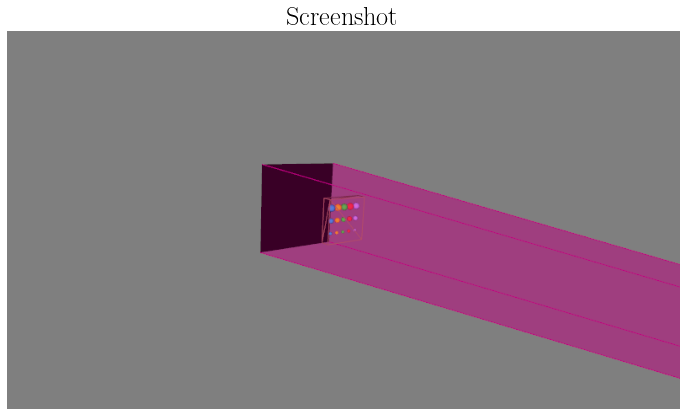

In [20]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig('plots/screenshot-beam-off-monoE-80keV.pdf')
plt.savefig('plots/screenshot-beam-off-monoE-80keV.png')

Compute an X-ray image and add it to the list of projections

In [21]:
# gvxr.enableArtefactFilteringOnCPU()
# gvxr.enableArtefactFilteringOnGPU()
gvxr.disableArtefactFiltering()
x_ray_image = np.array(gvxr.computeXRayImage())
imsave('gVirtualXRay_output_data/projection_raw_monoE-80keV.tif', x_ray_image.astype(np.single))
print(np.max(x_ray_image))

0.07999999821186066


Normalise the data

In [22]:
total_energy_in_keV = 0.0
for energy, count in zip(energy_set, count_set):
    total_energy_in_keV += energy * count
    
total_energy_in_MeV = total_energy_in_keV * 0.001

In [23]:
white = np.ones(x_ray_image.shape) * total_energy_in_MeV
dark = np.zeros(x_ray_image.shape)

x_ray_image = (x_ray_image - dark) / (white - dark)

Save the corresponding image

In [24]:
imsave('gVirtualXRay_output_data/projection_corrected_monoE-80keV.tif', x_ray_image.astype(np.single))

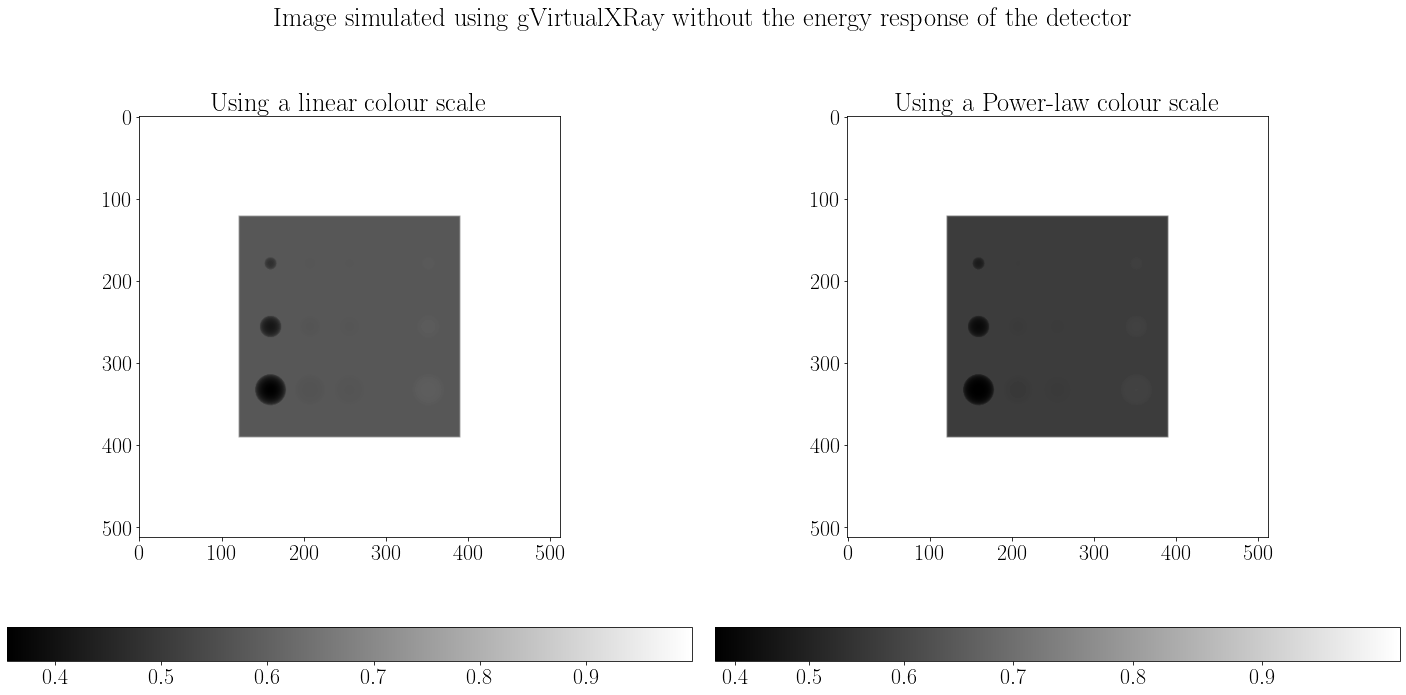

In [25]:
plt.figure(figsize= (20,10))

plt.suptitle("Image simulated using gVirtualXRay without the energy response of the detector", y=1.02)

plt.subplot(121)
plt.imshow(x_ray_image, cmap="gray")
plt.colorbar(orientation='horizontal')
plt.title("Using a linear colour scale")

plt.subplot(122)
plt.imshow(x_ray_image, norm=PowerNorm(gamma=1./0.75), cmap="gray")
plt.colorbar(orientation='horizontal')
plt.title("Using a Power-law colour scale")

plt.tight_layout()

plt.savefig('plots/x_ray_image_without_detector_response-monoE-80keV.pdf')
plt.savefig('plots/x_ray_image_without_detector_response-monoE-80keV.png')

Compare the manual implementation with gvxr's

In [26]:
def compareImages(gate_image, gvxr_image, caption):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 20))

    relative_error = 100 * (gate_image - gvxr_image) / gate_image
    comp_equalized = compare_images(gate_image, gvxr_image, method='checkerboard', n_tiles=(15,15))

    im1=axes.flat[0].imshow(comp_equalized, cmap="gray", vmin=0.25, vmax=1)
    axes.flat[0].set_title(caption)
    axes.flat[0].set_xticks([])
    axes.flat[0].set_yticks([])

    im2=axes.flat[1].imshow(relative_error, cmap="RdBu", vmin=-3, vmax=3)
    axes.flat[1].set_title("Relative error (in \%)")
    axes.flat[1].set_xticks([])
    axes.flat[1].set_yticks([])

    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                        wspace=0.2, hspace=0.02)

    # add an axes, lower left corner in [0.83, 0.1] measured in figure coordinate with axes width 0.02 and height 0.8

    cb_ax = fig.add_axes([0.83, 0.425, 0.02, 0.15])
    cbar = fig.colorbar(im2, cax=cb_ax)

    # set the colorbar ticks and tick labels
    # cbar.set_ticks(np.arange(0, 1.1, 0.5))
    # cbar.set_ticklabels(['low', 'medium', 'high'])

    # plt.show()

    # plt.tight_layout()

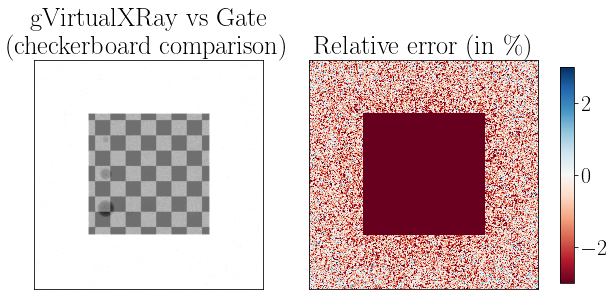

In [27]:
compareImages(x_ray_image, gate_image, "gVirtualXRay vs Gate\n(checkerboard comparison)")
plt.savefig('plots/comparison-monoE-80keV.pdf')
plt.savefig('plots/comparison-monoE-80keV.png')

## Comparison the analytic simulation with the Monte Carlo simulation

### Quantitative validation

Compute image metrics between the two simulated images:

1. [mean absolute percentage error (MAPE)](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error), also known as mean absolute percentage deviation (MAPD), and
2. [zero-mean normalised cross-correlation (ZNCC)](https://en.wikipedia.org/wiki/Cross-correlation#Zero-normalized_cross-correlation_(ZNCC)). 

We use this two metrics as one is a disimilarity measurement (MAPE), one is a similarity measurement (ZNCC), and both can be expressed as a percentage, which eases the interpretation of the numerical values.

In [28]:
MAPE = mape(gate_image, x_ray_image)
ZNCC = np.mean((gate_image - gate_image.mean()) / gate_image.std() * (x_ray_image - x_ray_image.mean()) / x_ray_image.std())

print("MAPE:", "{0:0.2f}".format(100 * MAPE) + "%")
print("ZNCC:", "{0:0.2f}".format(100 * ZNCC) + "%")

MAPE: 9.07%
ZNCC: 95.79%


MAPE is very small (less than 1%) and ZNCC is very high (more than 99%). We can conclude that the two images are similar. The main difference lie in the Poisson noise affecting the Monte Carlo simulation.

### Qualitative validation

Checkboard comparison

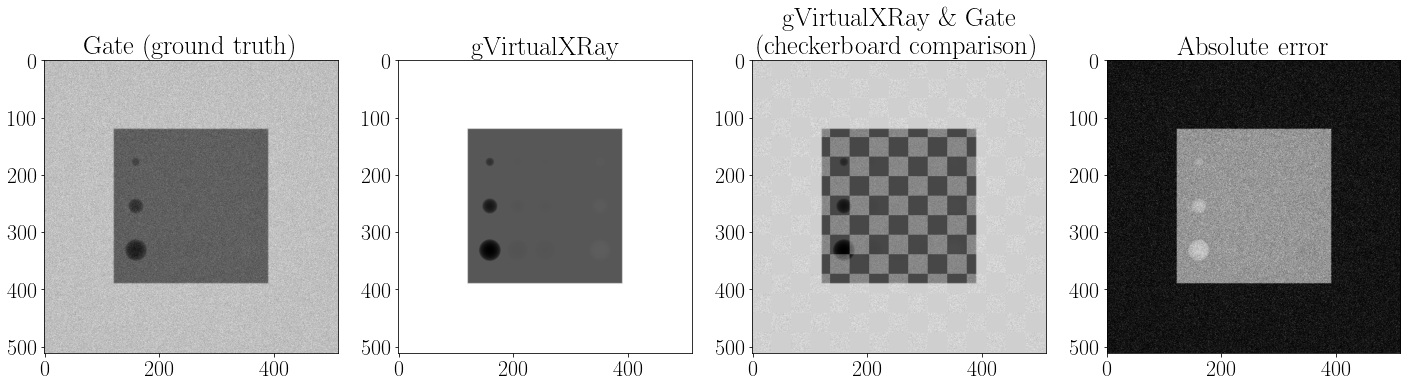

In [29]:
absolute_error = np.abs(gate_image - x_ray_image)
comp_equalized = compare_images(gate_image, x_ray_image, method='checkerboard', n_tiles=(15,15))

plt.figure(figsize= (20,10))

plt.subplot(141)
plt.imshow(gate_image, cmap="gray")#, vmin=0.25, vmax=1)
plt.title("Gate (ground truth)")

plt.subplot(142)
plt.imshow(x_ray_image, cmap="gray")#, vmin=0.25, vmax=1)
plt.title("gVirtualXRay")

plt.subplot(143)
plt.imshow(comp_equalized, cmap="gray")#, vmin=0.25, vmax=1)
plt.title("gVirtualXRay \\& Gate\n (checkerboard comparison)")

plt.subplot(144)
plt.imshow(absolute_error, cmap="gray")#, vmin=0.25, vmax=1)
plt.title("Absolute error")

plt.tight_layout()

plt.savefig('plots/full_comparison-monoE-80keV.pdf')
plt.savefig('plots/full_comparison-monoE-80keV.png')

In [30]:
font = {'size'   : 12
       }
matplotlib.rc('font', **font)

Plot the profiles

In [31]:
font = {'size'   : 22
       }
matplotlib.rc('font', **font)

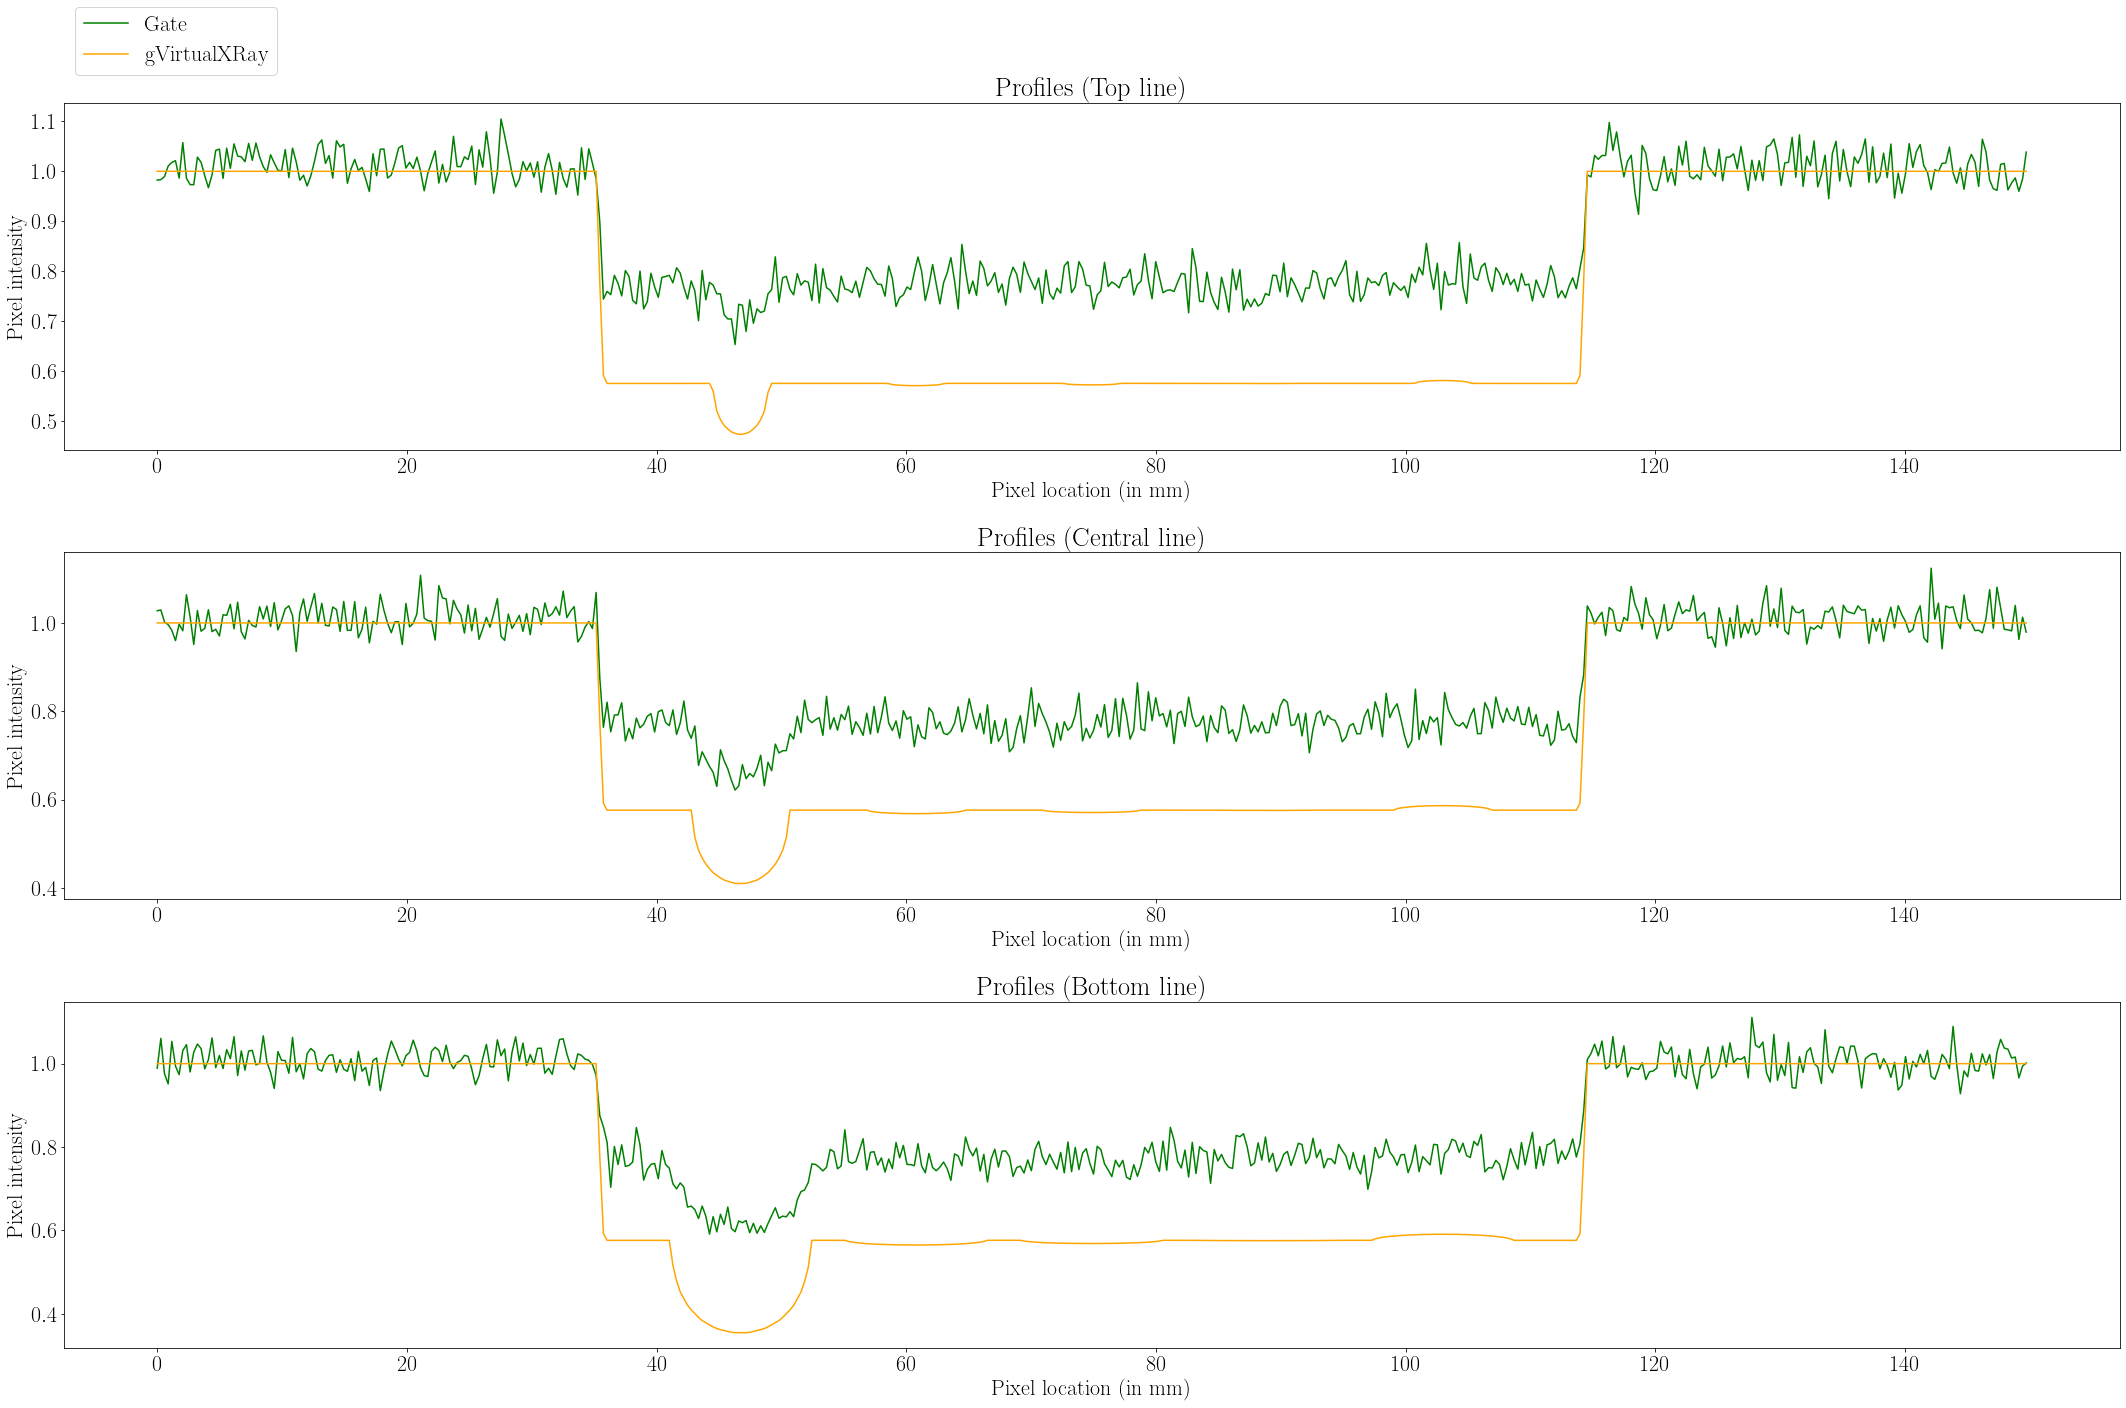

In [36]:
plt.figure(figsize= (30,20))

offset_line = 20 * (json2gvxr.params["Source"]["Position"][2] - json2gvxr.params["Detector"]["Position"][2]) / json2gvxr.params["Source"]["Position"][2]

spacing = json2gvxr.params["Detector"]["Size"][0] / json2gvxr.params["Detector"]["NumberOfPixels"][0]

x = np.arange(0.0, json2gvxr.params["Detector"]["Size"][0], spacing)

plt.subplot(311)
plt.title("Profiles (Top line)")
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2 - offset_line * json2gvxr.params["Detector"]["NumberOfPixels"][0] / json2gvxr.params["Detector"]["Size"][0])
plt.plot(x, gate_image[y_coord], label="Gate", color="green")
plt.plot(x, x_ray_image[y_coord], label="gVirtualXRay", color="orange")
plt.xlabel("Pixel location (in mm)")
plt.ylabel("Pixel intensity")
plt.legend(loc='lower left', bbox_to_anchor=(0.0, 1.05))





plt.subplot(312)
plt.title("Profiles (Central line)")
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2)
plt.plot(x, gate_image[y_coord], color="green")
plt.plot(x, x_ray_image[y_coord], color="orange")
plt.xlabel("Pixel location (in mm)")
plt.ylabel("Pixel intensity")

plt.subplot(313)
plt.title("Profiles (Bottom line)")
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2 + offset_line * json2gvxr.params["Detector"]["NumberOfPixels"][0] / json2gvxr.params["Detector"]["Size"][0])
plt.plot(x, gate_image[y_coord], color="green")
plt.plot(x, x_ray_image[y_coord], color="orange")
plt.xlabel("Pixel location (in mm)")
plt.ylabel("Pixel intensity")

plt.tight_layout()

plt.savefig('plots/profiles-monoE-80keV.pdf')
plt.savefig('plots/profiles-monoE-80keV.png')

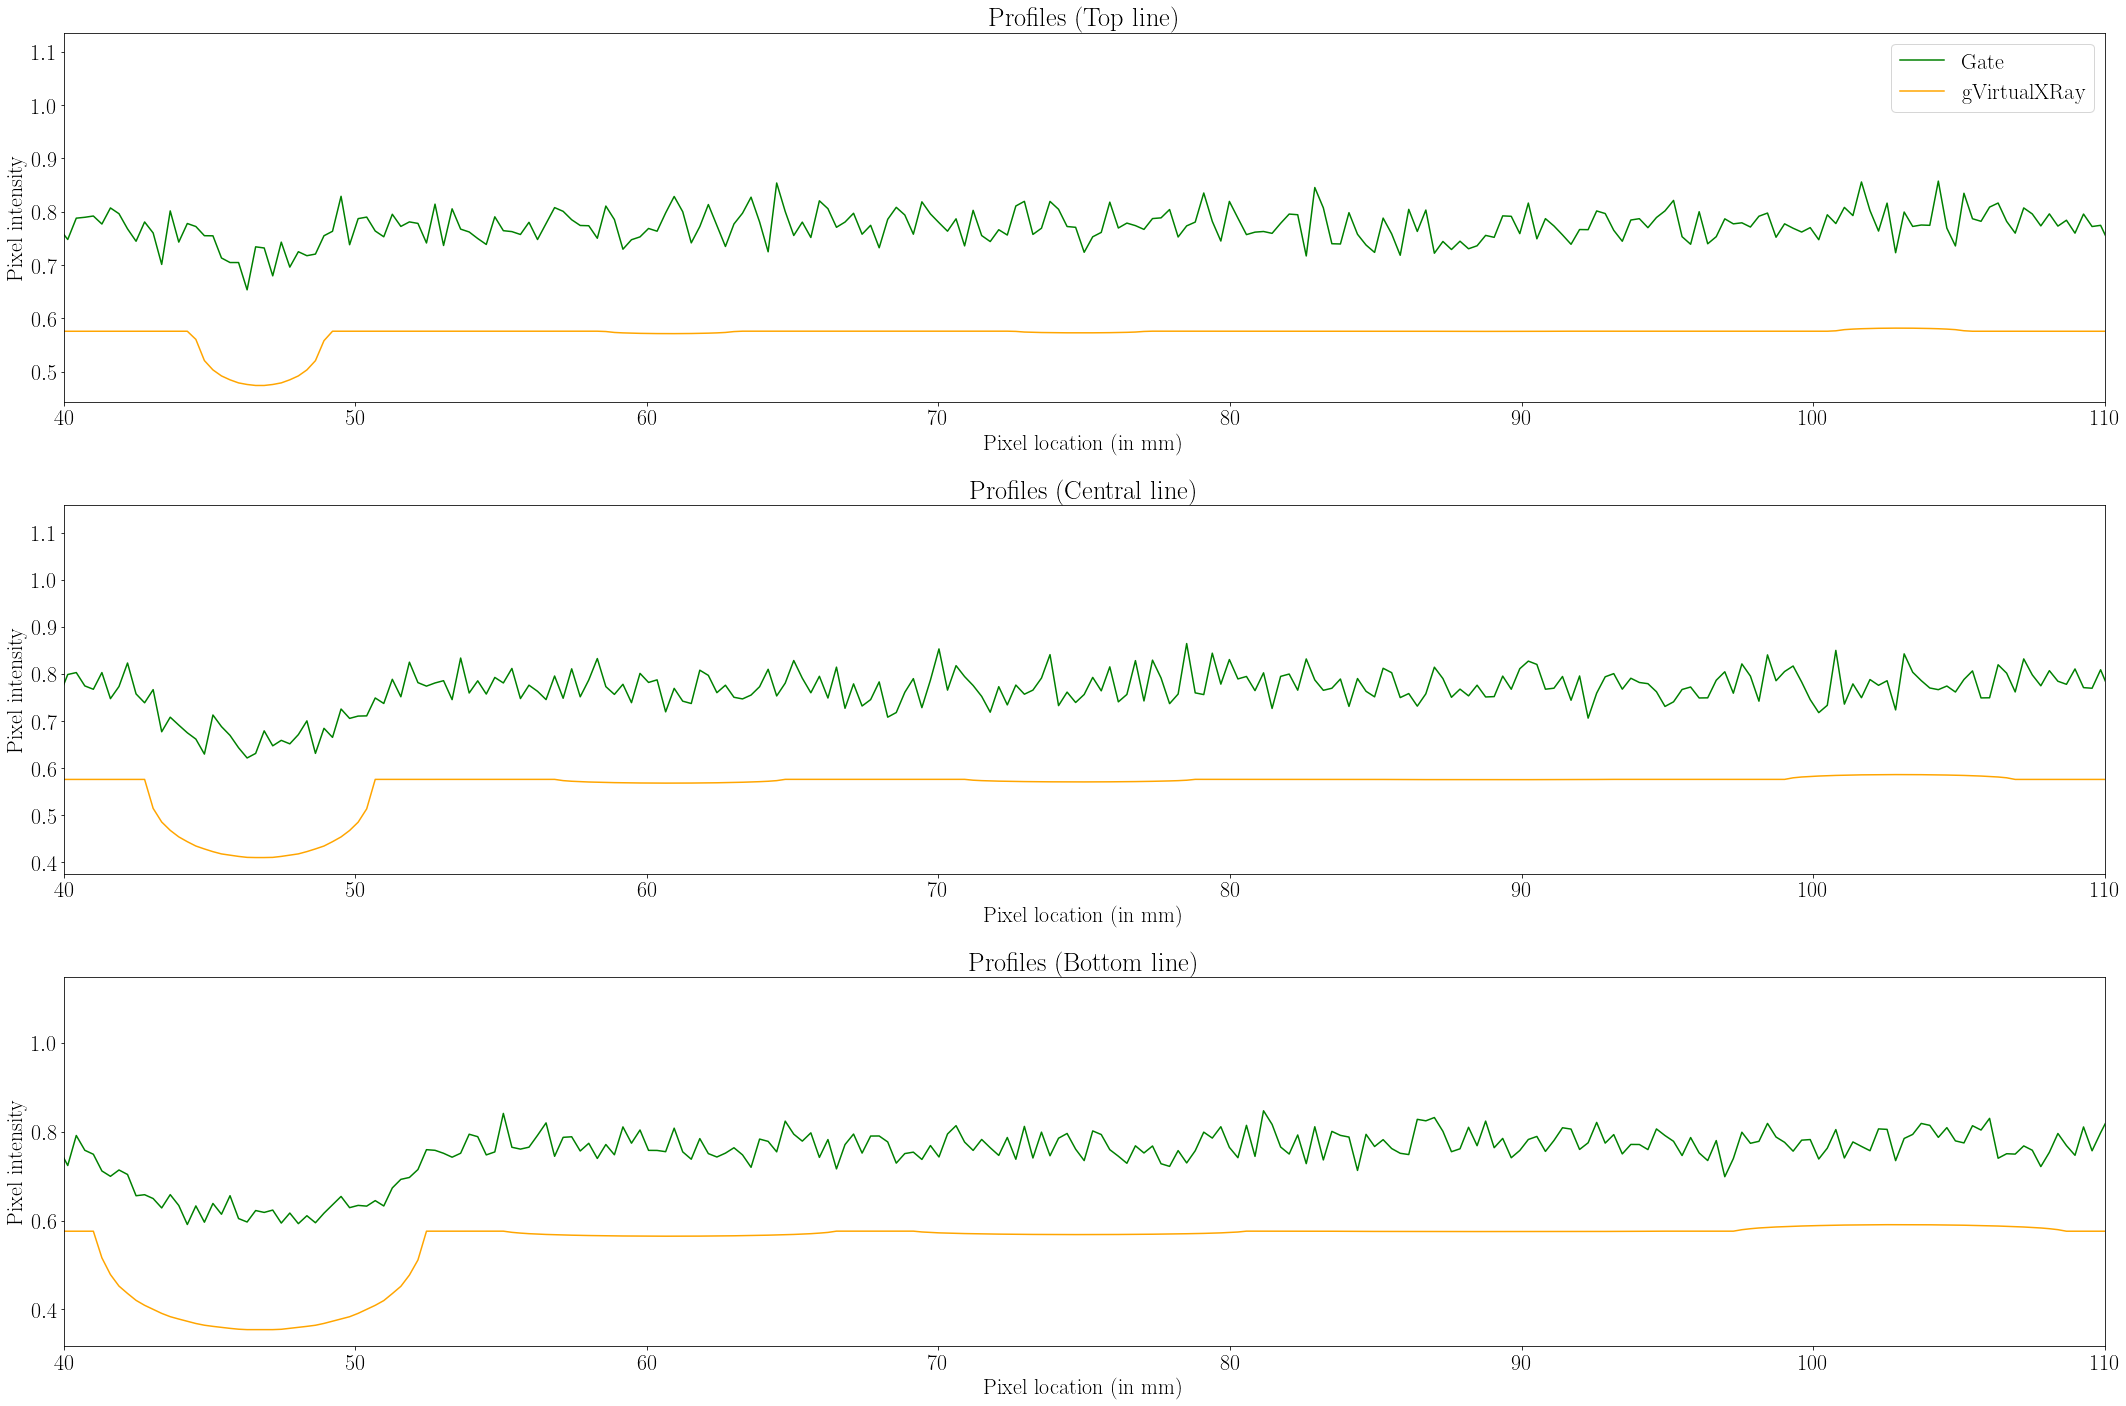

In [33]:
min_limit = round(40)
max_limit = round(512 * spacing - 40)

plt.figure(figsize= (30,20))
offset_line = 20 * (json2gvxr.params["Source"]["Position"][2] - json2gvxr.params["Detector"]["Position"][2]) / json2gvxr.params["Source"]["Position"][2]

spacing = json2gvxr.params["Detector"]["Size"][0] / json2gvxr.params["Detector"]["NumberOfPixels"][0]

x = np.arange(0.0, json2gvxr.params["Detector"]["Size"][0], spacing)

plt.subplot(311)
plt.title("Profiles (Top line)")
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2 - offset_line * json2gvxr.params["Detector"]["NumberOfPixels"][0] / json2gvxr.params["Detector"]["Size"][0])
plt.plot(x, gate_image[y_coord], label="Gate", color="green")
plt.plot(x, x_ray_image[y_coord], label="gVirtualXRay", color="orange")
plt.xlabel("Pixel location (in mm)")
plt.ylabel("Pixel intensity")
plt.legend()
plt.xlim((min_limit, max_limit))

plt.subplot(312)
plt.title("Profiles (Central line)")
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2)
plt.plot(x, gate_image[y_coord], color="green")
plt.plot(x, x_ray_image[y_coord], color="orange")
plt.xlabel("Pixel location (in mm)")
plt.ylabel("Pixel intensity")
plt.xlim((min_limit, max_limit))

plt.subplot(313)
plt.title("Profiles (Bottom line)")
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2 + offset_line * json2gvxr.params["Detector"]["NumberOfPixels"][0] / json2gvxr.params["Detector"]["Size"][0])
plt.plot(x, gate_image[y_coord], color="green")
plt.plot(x, x_ray_image[y_coord], color="orange")
plt.xlabel("Pixel location (in mm)")
plt.ylabel("Pixel intensity")
plt.xlim((min_limit, max_limit))

plt.tight_layout()

plt.savefig('plots/profiles-zoom-monoE-80keV.pdf')
plt.savefig('plots/profiles-zoom-monoE-80keV.png')

Plot the same profiles but of the checkerboard comparison. The noisy parts correspond to the Monte Carlo simulation. Both the Monte Carlo and analytic simulations are comparable.

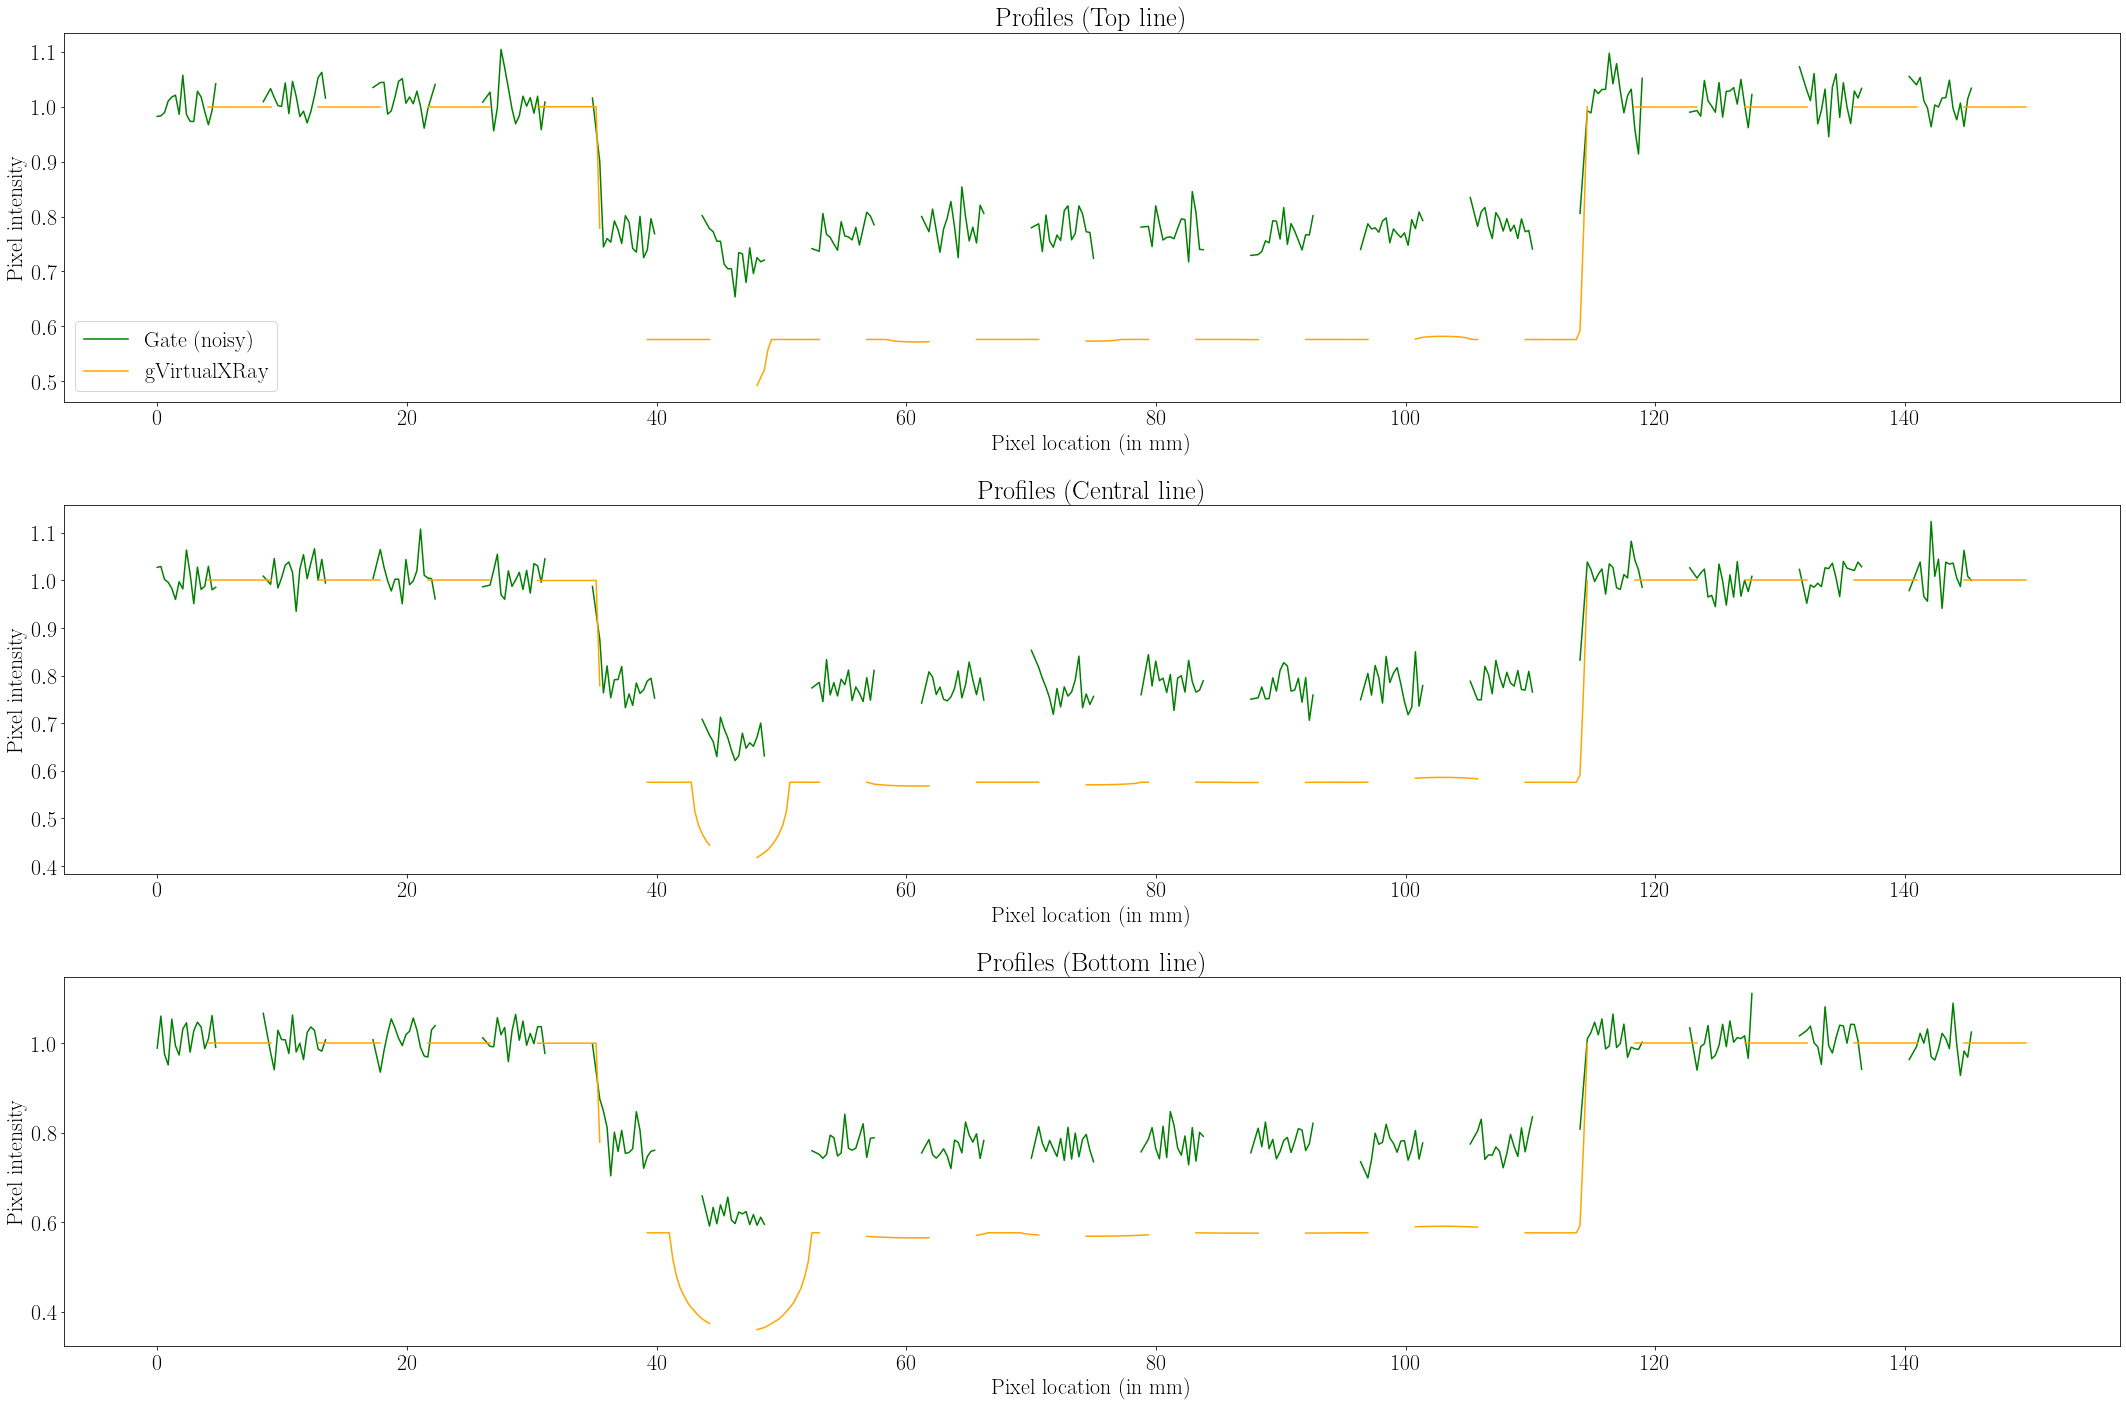

In [34]:
plt.figure(figsize= (30,20))

offset_line = 20 * (json2gvxr.params["Source"]["Position"][2] - json2gvxr.params["Detector"]["Position"][2]) / json2gvxr.params["Source"]["Position"][2]

spacing = json2gvxr.params["Detector"]["Size"][0] / json2gvxr.params["Detector"]["NumberOfPixels"][0]

x = np.arange(0.0, json2gvxr.params["Detector"]["Size"][0], spacing)

x_gate = []
x_gvxr_without_noise = []
temp = []

use_simulation = 0

for i in range(x_ray_image.shape[1]):
    
    temp.append(i)
    
    if not i % 15 and i != 0:
        temp.append(i+1)
        if use_simulation == 0:
            x_gate.append(temp)
            use_simulation += 1
        elif use_simulation == 1:
            x_gvxr_without_noise.append(temp)
            use_simulation = 0

        temp = []
        temp.append(i-1)
        
plt.subplot(311)
plt.title("Profiles (Top line)")
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2 - offset_line * json2gvxr.params["Detector"]["NumberOfPixels"][0] / json2gvxr.params["Detector"]["Size"][0])

i = 0
for sub_x in x_gate:
    y = gate_image[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="Gate (noisy)", color='green')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='green')
    i += 1

i = 0
for sub_x in x_gvxr_without_noise:
    y = x_ray_image[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="gVirtualXRay", color='orange')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='orange')
    i += 1

plt.xlabel("Pixel location (in mm)")
plt.ylabel("Pixel intensity")
plt.legend()

plt.subplot(312)
plt.title("Profiles (Central line)")
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2)

i = 0
for sub_x in x_gate:
    y = gate_image[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="Gate (noisy)", color='green')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='green')
    i += 1

i = 0
for sub_x in x_gvxr_without_noise:
    y = x_ray_image[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="gVirtualXRay", color='orange')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='orange')
    i += 1


plt.xlabel("Pixel location (in mm)")
plt.ylabel("Pixel intensity")

plt.subplot(313)
plt.title("Profiles (Bottom line)")
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2 + offset_line * json2gvxr.params["Detector"]["NumberOfPixels"][0] / json2gvxr.params["Detector"]["Size"][0])

i = 0
for sub_x in x_gate:
    y = gate_image[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="Gate (noisy)", color='green')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='green')
    i += 1

i = 0
for sub_x in x_gvxr_without_noise:
    y = x_ray_image[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="gVirtualXRay", color='orange')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='orange')
    i += 1

plt.xlabel("Pixel location (in mm)")
plt.ylabel("Pixel intensity")

plt.tight_layout()

plt.savefig('plots/profiles-checkerboard-monoE-80keV.pdf')
plt.savefig('plots/profiles-checkerboard-monoE-80keV.png')

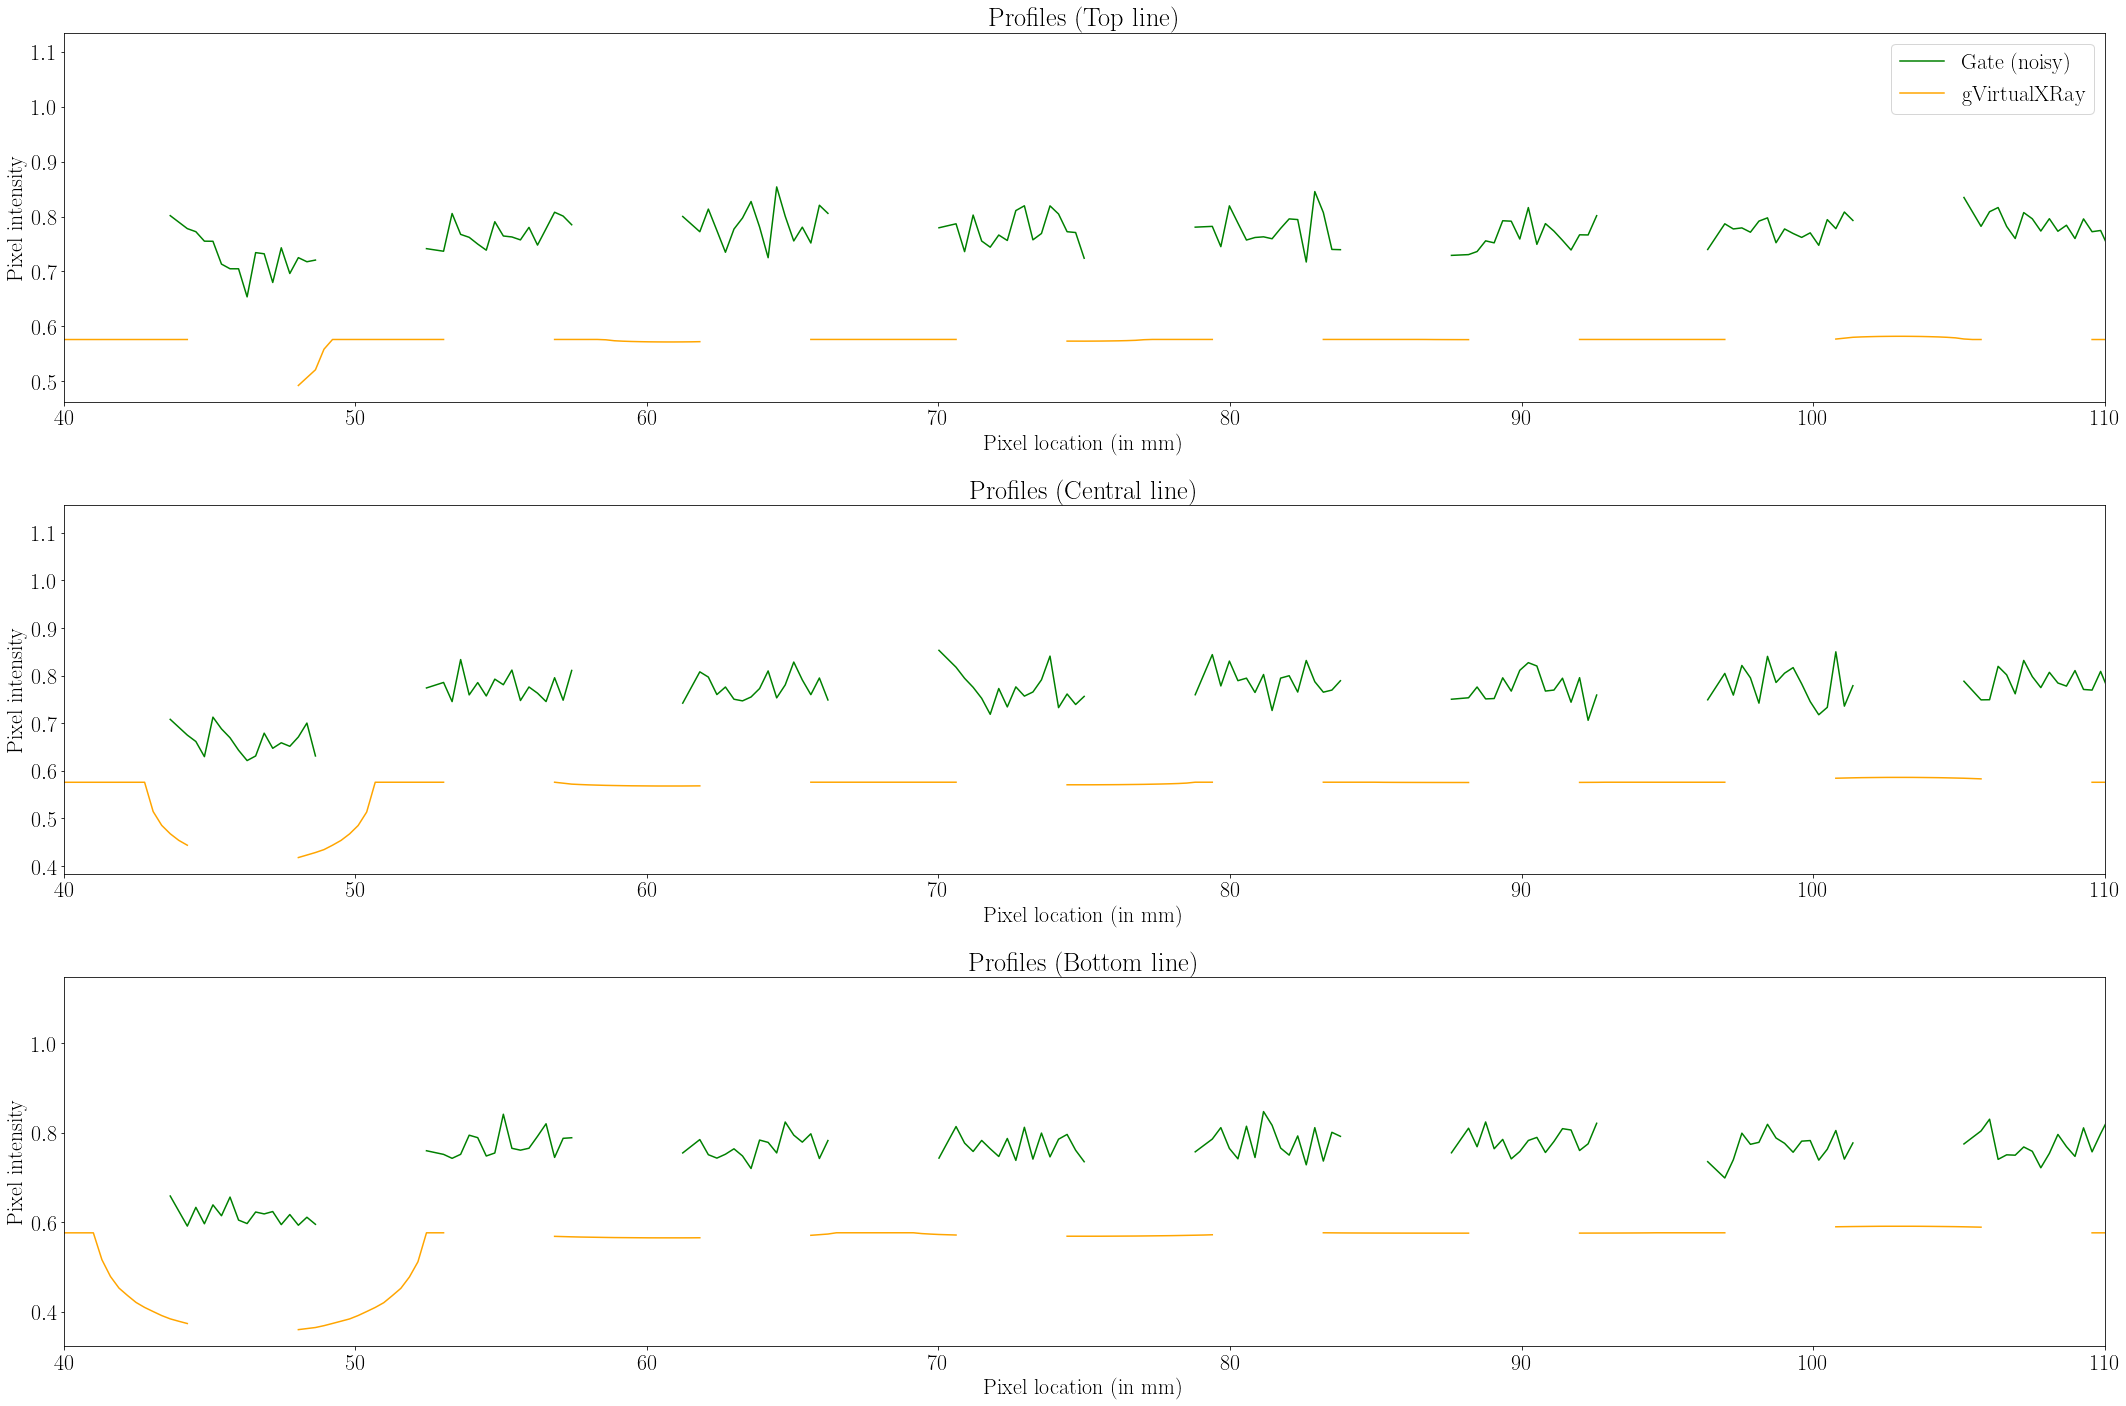

In [38]:
plt.figure(figsize= (30,20))

offset_line = 20 * (json2gvxr.params["Source"]["Position"][2] - json2gvxr.params["Detector"]["Position"][2]) / json2gvxr.params["Source"]["Position"][2]

spacing = json2gvxr.params["Detector"]["Size"][0] / json2gvxr.params["Detector"]["NumberOfPixels"][0]

x = np.arange(0.0, json2gvxr.params["Detector"]["Size"][0], spacing)

x_gate = []
x_gvxr_without_noise = []
temp = []

use_simulation = 0

for i in range(x_ray_image.shape[1]):
    
    temp.append(i)
    
    if not i % 15 and i != 0:
        temp.append(i+1)
        if use_simulation == 0:
            x_gate.append(temp)
            use_simulation += 1
        elif use_simulation == 1:
            x_gvxr_without_noise.append(temp)
            use_simulation = 0

        temp = []
        temp.append(i-1)

plt.subplot(311)
plt.title("Profiles (Top line)")
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2 - offset_line * json2gvxr.params["Detector"]["NumberOfPixels"][0] / json2gvxr.params["Detector"]["Size"][0])

i = 0
for sub_x in x_gate:
    y = gate_image[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="Gate (noisy)", color='green')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='green')
    i += 1

i = 0
for sub_x in x_gvxr_without_noise:
    y = x_ray_image[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="gVirtualXRay", color='orange')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='orange')
    i += 1

 
plt.xlabel("Pixel location (in mm)")
plt.ylabel("Pixel intensity")
plt.legend()
plt.xlim((min_limit, max_limit))

plt.subplot(312)
plt.title("Profiles (Central line)")
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2)

i = 0
for sub_x in x_gate:
    y = gate_image[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="Gate (noisy)", color='green')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='green')
    i += 1

i = 0
for sub_x in x_gvxr_without_noise:
    y = x_ray_image[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="gVirtualXRay", color='orange')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='orange')
    i += 1

plt.xlabel("Pixel location (in mm)")
plt.ylabel("Pixel intensity")
plt.xlim((min_limit, max_limit))

plt.subplot(313)
plt.title("Profiles (Bottom line)")
# plt.yscale("log")
y_coord = round(json2gvxr.params["Detector"]["NumberOfPixels"][0] / 2 + offset_line * json2gvxr.params["Detector"]["NumberOfPixels"][0] / json2gvxr.params["Detector"]["Size"][0])

i = 0
for sub_x in x_gate:
    y = gate_image[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="Gate (noisy)", color='green')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='green')
    i += 1

i = 0
for sub_x in x_gvxr_without_noise:
    y = x_ray_image[y_coord][sub_x]
    if i == 0:
        plt.plot(np.array(sub_x) * spacing, y, label="gVirtualXRay", color='orange')
    else:
        plt.plot(np.array(sub_x) * spacing, y, color='orange')
    i += 1


plt.xlabel("Pixel location (in mm)")
plt.ylabel("Pixel intensity")
plt.xlim((min_limit, max_limit))

plt.tight_layout()

plt.savefig('plots/profiles-checkerboard-zoom-monoE-80keV.pdf')
plt.savefig('plots/profiles-checkerboard-zoom-monoE-80keV.png')

## All done

Destroy the window

In [39]:
gvxr.destroyAllWindows()

gvxrStatus:	Destroy all the windows
gvxrStatus:	Destroy window 0(0x5654a3639b40)
